In [15]:
# data manipulations
import numpy as np
import pandas as pd

# data preaparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# dealing with images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for writing the models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

# metrics 
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import AUC

#visualization
import matplotlib.pyplot as plt


In [84]:
def print_results(predictions, test):
    y_pred = np.argmax(predictions, axis=1)
    y_true = test.labels
    
    # confusion matrix
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    # classification report
    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred))


def graphing_training_validation(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('accuracy') 
    plt.xlabel('epoch')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('loss') 
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

Load images metadata

In [12]:
metadata = pd.read_csv("image_metadata.csv")
metadata.head()

,Path,Label
0,img_data/Bleatings/0.png,Bleatings
1,img_data/Bleatings/1.png,Bleatings
2,img_data/Bleatings/2.png,Bleatings
3,img_data/Bleatings/3.png,Bleatings
4,img_data/Bleatings/4.png,Bleatings


Split the data in train, validation and test set.

In [36]:
# get train/test dataframe
train_df, test_df = train_test_split(metadata, 
                                   test_size = 0.10, 
                                   random_state = 2018,
                                   stratify = metadata['Label'])
print(f'Train {np.shape(train_df)} and test {np.shape(test_df)}')

Train (6304, 2) and test (701, 2)


Prepare train and validation iamges

In [34]:
path_dir = "./"

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    validation_split = 0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path_dir,
    x_col="Path",
    y_col="Label",
    target_size=(128,94),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='training'
)
validation_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path_dir,
    x_col="Path",
    y_col="Label",
    target_size=(128,94),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='validation'
)

Found 5044 validated image filenames belonging to 3 classes.
Found 1260 validated image filenames belonging to 3 classes.


Prepare test images

In [54]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path_dir,
    x_col="Path",
    y_col="Label",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(128,94))

Found 701 validated image filenames belonging to 3 classes.


# Convolutional Neural Network on log Mel-spectrogram images

Next I'm going to train 3 CNN models to find out which is the best model.<br>Follow the definition of some fixed parameters for training like optimizer and early stopping.

In [39]:
adam = keras.optimizers.Adam(lr=0.001)
batchsize = 32
epochs = 50
metrics = [
    "accuracy",
    AUC(curve="ROC", name="auroc")
]
callbacks=[
    EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)
]

C:\Users\Nicolas Facchinetti\.conda\envs\progapr\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [59]:
def compile_and_train(model, train, validation):
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=metrics)
    history = model.fit(train,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_data=validation,
                    callbacks=callbacks)
    return history, model

## First CNN 

In [65]:
model = Sequential([
    #1st hidden layer
    Conv2D(32, (3, 3), activation='relu', strides=(2, 2), input_shape=input_shape),
    MaxPool2D((2, 2)),
    #2nd hidden layer
    Conv2D(64, (3, 3), activation='relu', strides=(2, 2), padding="same"),
    MaxPool2D((2, 2)),
    #3rd hidden layer
    Conv2D(128, (3, 3), activation='relu', padding="same"),
    MaxPool2D((2, 2)),
    #ANN
    Flatten(),
    Dropout(rate=0.5),
    Dense(units = 128, activation='relu'),
    Dense(units = 64, activation='relu'),
    Dropout(rate=0.25),
    #Output layer
    Dense(units= 3, activation='softmax'),
]) 
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 63, 46, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 23, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 6, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 6, 128)         73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 4, 3, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1536)             

In [66]:
history, model = compile_and_train(model, train_generator, validation_generator)

Epoch 1/50
158/158 [==============================] - 18s 108ms/step - loss: 0.7806 - accuracy: 0.5696 - auroc: 0.8554 - val_loss: 0.5746 - val_accuracy: 0.6397 - val_auroc: 0.8763
Epoch 2/50
158/158 [==============================] - 17s 105ms/step - loss: 0.5905 - accuracy: 0.6521 - auroc: 0.8744 - val_loss: 0.5547 - val_accuracy: 0.6524 - val_auroc: 0.8833
Epoch 3/50
158/158 [==============================] - 17s 105ms/step - loss: 0.5516 - accuracy: 0.6959 - auroc: 0.8933 - val_loss: 0.5211 - val_accuracy: 0.7079 - val_auroc: 0.9041
Epoch 4/50
158/158 [==============================] - 16s 104ms/step - loss: 0.5410 - accuracy: 0.7010 - auroc: 0.8988 - val_loss: 0.5090 - val_accuracy: 0.7270 - val_auroc: 0.9137
Epoch 5/50
158/158 [==============================] - 16s 103ms/step - loss: 0.5210 - accuracy: 0.7326 - auroc: 0.9095 - val_loss: 0.4917 - val_accuracy: 0.7516 - val_auroc: 0.9195
Epoch 6/50
158/158 [==============================] - 17s 106ms/step - loss: 0.5130 - accuracy:

In [86]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auroc', 'val_loss', 'val_accuracy', 'val_auroc'])

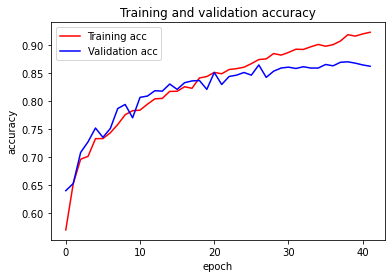

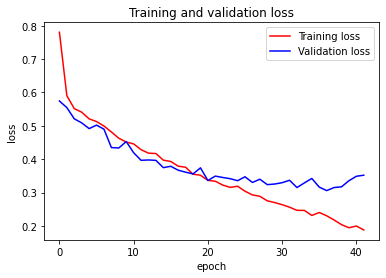

In [85]:
graphing_training_validation(history)

In [69]:
test_accuracy = model.evaluate(validation_generator)

40/40 [==============================] - 3s 81ms/step - loss: 0.3059 - accuracy: 0.8627 - auroc: 0.9726


In [74]:
prediction = model.predict(test_generator)

In [75]:
print_results(prediction, test_generator)

Confusion matrix:
[[166  60   9]
 [ 31 185   4]
 [  7   1 238]]

Classification report:

              precision    recall  f1-score   support

           0       0.81      0.71      0.76       235
           1       0.75      0.84      0.79       220
           2       0.95      0.97      0.96       246

    accuracy                           0.84       701
   macro avg       0.84      0.84      0.84       701
weighted avg       0.84      0.84      0.84       701



## Second CNN

In [62]:
# build a sequential model
model1 = Sequential([
    InputLayer(input_shape=(128, 94, 3)),
    # 1st conv block
    Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    # 2nd conv block
    Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    BatchNormalization(),
    # 3rd conv block
    Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'),
    MaxPool2D(pool_size=(2, 2), padding='valid'),
    BatchNormalization(),
    # ANN block
    Flatten(),
    Dense(units=100, activation='relu'),
    Dense(units=50, activation='relu'),
    Dropout(0.25),
    # output layer
    Dense(units=3, activation='softmax')
])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 94, 25)       1900      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 47, 25)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 24, 50)        31300     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 12, 50)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 12, 50)        200       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 6, 70)          31570     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 3, 70)         

In [67]:
history1, model1 = compile_and_train(model1, train_generator, validation_generator)

Epoch 1/50
158/158 [==============================] - 23s 119ms/step - loss: 0.7398 - accuracy: 0.6261 - auroc: 0.8732 - val_loss: 6.9198 - val_accuracy: 0.3262 - val_auroc: 0.5187
Epoch 2/50
158/158 [==============================] - 18s 114ms/step - loss: 0.5296 - accuracy: 0.7462 - auroc: 0.9145 - val_loss: 0.5652 - val_accuracy: 0.7302 - val_auroc: 0.9066
Epoch 3/50
158/158 [==============================] - 19s 118ms/step - loss: 0.4867 - accuracy: 0.7696 - auroc: 0.9283 - val_loss: 0.4619 - val_accuracy: 0.7857 - val_auroc: 0.9366
Epoch 4/50
158/158 [==============================] - 19s 120ms/step - loss: 0.4385 - accuracy: 0.7908 - auroc: 0.9421 - val_loss: 1.0672 - val_accuracy: 0.6786 - val_auroc: 0.8431
Epoch 5/50
158/158 [==============================] - 19s 121ms/step - loss: 0.4056 - accuracy: 0.8113 - auroc: 0.9500 - val_loss: 0.6216 - val_accuracy: 0.7500 - val_auroc: 0.9096
Epoch 6/50
158/158 [==============================] - 19s 119ms/step - loss: 0.4028 - accuracy:

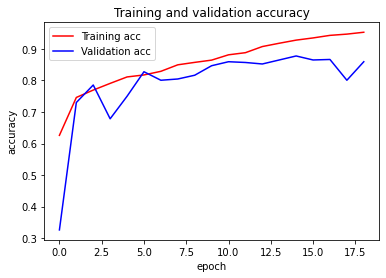

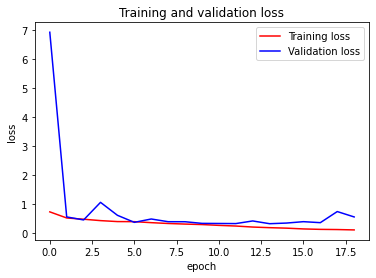

In [87]:
graphing_training_validation(history1)

In [72]:

test_accuracy = model1.evaluate(validation_generator)

40/40 [==============================] - 3s 84ms/step - loss: 0.3325 - accuracy: 0.8651 - auroc: 0.9701


In [78]:
pred1 = model1.predict(test_generator)
print_results(pred1, test_generator)

Confusion matrix:
[[165  55  15]
 [ 32 180   8]
 [  4   0 242]]

Classification report:

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       235
           1       0.77      0.82      0.79       220
           2       0.91      0.98      0.95       246

    accuracy                           0.84       701
   macro avg       0.83      0.83      0.83       701
weighted avg       0.84      0.84      0.83       701



## Third CNN 

In [63]:
model2 = tf.keras.models.Sequential([
    #first_convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 94, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #second_convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #third_convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #fourth_convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #out ANN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') 
]) 
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 92, 16)       448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 46, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 44, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 22, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 10, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 8, 64)        

In [68]:
history2, model2 = compile_and_train(model2, train_generator, validation_generator)

Epoch 1/50
158/158 [==============================] - 21s 122ms/step - loss: 0.7062 - accuracy: 0.6253 - auroc: 0.8710 - val_loss: 0.5419 - val_accuracy: 0.6548 - val_auroc: 0.8904
Epoch 2/50
158/158 [==============================] - 19s 119ms/step - loss: 0.5534 - accuracy: 0.6963 - auroc: 0.8935 - val_loss: 0.5098 - val_accuracy: 0.7365 - val_auroc: 0.9164
Epoch 3/50
158/158 [==============================] - 19s 121ms/step - loss: 0.5142 - accuracy: 0.7181 - auroc: 0.9090 - val_loss: 0.4884 - val_accuracy: 0.7579 - val_auroc: 0.9240
Epoch 4/50
158/158 [==============================] - 19s 119ms/step - loss: 0.4956 - accuracy: 0.7326 - auroc: 0.9150 - val_loss: 0.4594 - val_accuracy: 0.7651 - val_auroc: 0.9292
Epoch 5/50
158/158 [==============================] - 19s 119ms/step - loss: 0.4720 - accuracy: 0.7565 - auroc: 0.9263 - val_loss: 0.4397 - val_accuracy: 0.7762 - val_auroc: 0.9363
Epoch 6/50
158/158 [==============================] - 19s 117ms/step - loss: 0.4521 - accuracy:

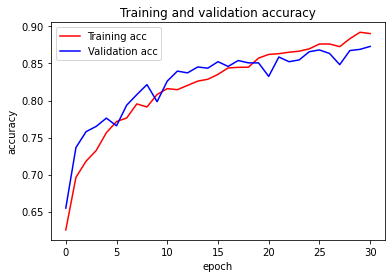

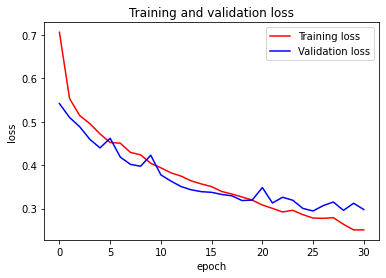

In [88]:
graphing_training_validation(history2)

In [76]:
test_accuracy = model2.evaluate(validation_generator)

40/40 [==============================] - 3s 82ms/step - loss: 0.2943 - accuracy: 0.8683 - auroc: 0.9739


In [79]:
pred2 = model2.predict(test_generator)
print_results(pred2, test_generator)

Confusion matrix:
[[192  39   4]
 [ 42 178   0]
 [  7   0 239]]

Classification report:

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       235
           1       0.82      0.81      0.81       220
           2       0.98      0.97      0.98       246

    accuracy                           0.87       701
   macro avg       0.87      0.87      0.87       701
weighted avg       0.87      0.87      0.87       701

